# A Machine Learning Tutorial for Veterinarians

***Nathan Bollig, DVM***  
Department of Computer Sciences, University of Wisconsin-Madison, Madison, WI  
Department of Pathobiological Sciences, School of Veterinary Medicine, University of Wisconsin-Madison, Madison, WI

## Introduction

This notebook documents setup information and code used for results to be presented at the Fetch dvm360 conference in Kansas City, MO in August, 2020. When available, a link to the proceedings paper and presentation slides will be included in this github repository. Please reach out with any comments, questions, or questions at nbollig (at) wisc (dot) edu.

## Reading in data

We start by importing most of the modules that are needed for this entire project.

In [2]:
import pandas as pd
import numpy as np
import os
import time
import pickle
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_func

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.impute import SimpleImputer

from pathlib import Path

seed = 1990
np.random.seed(seed)
pd.options.mode.chained_assignment = None

We will begin by loading in the raw data set. (Note that some features have been previously removed or encoded numerically for confidentiality.) We will perform some essential data preparation steps including: encoding categorical features, some formatting, and imputation of missing values.

In [3]:
def prep_data(data_dir=""):

    # Read in data set
    if data_dir != "":
        file = os.path.join(data_dir, "data.csv")
    else:
        file = "data.csv"
        
    data = pd.read_csv(file)
    
    # Create dictionary to store category mappings
    mappings = {}
    
    # Drop unamed index column
    data = data.drop(data.columns[0], axis=1)
    
    # Encode breed category
    def encode(data, mappings, col_name):
        le = LabelEncoder()
        data[col_name] = le.fit_transform(data[col_name])
        mappings[col_name] = dict(zip(le.classes_, le.transform(le.classes_)))
    
    encode(data, mappings, 'breed_cat')
    
    # Encode sex
    encode(data, mappings, 'sex')
    
    # Take only first 5 digits of zip code
    for i in range(len(data['zip'])):
        data['zip'][i] = data['zip'][i][0:5]
    
    data['zip'] = data['zip'].astype(int)
    
    # dob to string
    for i in range(len(data['dob'])):
        item = data['dob'][i]
        if isinstance(item, str):
            dt = datetime.strptime(data['dob'][i], '%Y-%m-%d')
            data['dob'][i] = dt.timestamp()
        elif np.isnan(item) == True:
            data['dob'][i] = 0
    
    # Impute missing dates of birth encoded as 0
    imp = SimpleImputer(missing_values=0, strategy='mean')   
    data['dob'] = imp.fit_transform(np.asarray(data['dob']).reshape((-1,1)))
    
    # Encode therapy
    for i in range(len(data['therapy'])):
        item = data['therapy'][i]
        if isinstance(item, str) == False and np.isnan(item) == True:
            data['therapy'][i] = "NA"
    
    encode(data, mappings, 'therapy')
    
    # Encode first_proc_date
    for i in range(len(data['first_proc_date'])):
        item = data['first_proc_date'][i]
        if isinstance(item, str):
            dt = datetime.strptime(data['first_proc_date'][i], '%Y-%m-%d')
            data['first_proc_date'][i] = dt.timestamp()
        elif np.isnan(item) == True:
            data['first_proc_date'][i] = 0
    
    data['first_proc_date'] = data['first_proc_date'].astype(float)
    
    # Encode first_proc_season
    for i in range(len(data['first_proc_season'])):
        item = data['first_proc_season'][i]
        if isinstance(item, str) == False and np.isnan(item) == True:
            data['first_proc_season'][i] = "NA"
            
    encode(data, mappings, 'first_proc_season')
    
    # Encode dob_season
    for i in range(len(data['dob_season'])):
        item = data['dob_season'][i]
        if isinstance(item, str) == False and np.isnan(item) == True:
            data['dob_season'][i] = "Unknown"
            
    encode(data, mappings, 'dob_season')
    
    # Encode first_dvm_code
    for i in range(len(data['first_dvm_code'])):
        item = data['first_dvm_code'][i]
        if isinstance(item, str) == False and np.isnan(item) == True:
            data['first_dvm_code'][i] = -1
        data['first_dvm_code'][i]= int(data['first_dvm_code'][i])
    
    # Encode RUCC
    for i in range(len(data['RUCC'])):
        item = data['RUCC'][i]
        if isinstance(item, str) == False and np.isnan(item) == True:
            data['RUCC'][i] = 0
    
    # Impute missing RUCC
    imp = SimpleImputer(missing_values=0, strategy='mean')   
    data['RUCC'] = imp.fit_transform(np.asarray(data['RUCC']).reshape((-1,1)))
    
    return data, mappings

In [4]:
data, mappings = prep_data()

Categorical features have been encoded as integers, with the mappings stored in `mappings` dictionary.

In [4]:
mappings

{'breed_cat': {'bulldog breed': 0,
  'hound': 1,
  'large breed': 2,
  'mixed breed': 3,
  'northern breed': 4,
  'other': 5,
  'pinscher': 6,
  'pointer': 7,
  'poodle': 8,
  'retriever': 9,
  'setter': 10,
  'shepherd': 11,
  'spaniel': 12,
  'spitz': 13,
  'terrier': 14,
  'toy breed': 15},
 'sex': {'F': 0, 'M': 1, 'N': 2, 'S': 3},
 'therapy': {'Allergy Shot': 0, 'NA': 1, 'Sublingual': 2},
 'first_proc_season': {'NA': 0,
  'fall': 1,
  'spring': 2,
  'summer': 3,
  'winter': 4},
 'dob_season': {'Unknown': 0,
  'fall': 1,
  'spring': 2,
  'summer': 3,
  'winter': 4}}

After processing, the dataset has the following columns:
 - `breed_cat`: Patient breed (Spaniel, Retriever, Shepherd, Pointer, Hound, Bulldog breed, Terrier, Setter, Northern breed, Poodle, Toy breed, Pinscher, Large breed, Spitz, Mixed breed, Other)
 - `sex`: Patient sex (female, male, neutered, spayed)
 - `zip`: ZIP code for patient address
 - `RUCC`: Rural-urban continuum codes (RUCC) characterizes county population numerically from 1 (largest) to 9 (smallest)
 - `case`: Case (1) or control (0)
 - `dob`: POSIX timestamp of patient date of birth
 - `therapy`: Patient therapy (allergy shot, sublingual, or none)
 - `first_proc_date`: POSIX timestamp of patient's first treatment date
 - `first_proc_season`: Season of patient's first season
 - `age_days`: Patient age at day of first treatment
 - `age_cat`: Ages are categorized as 1 ("young", less than 660 days) and 2 ("old", at least 660 days)
 - `first_dvm_code`: Numerical code representing attending DVM at first treatment
 - `tx_success`: Treatment success (1) or failure (0), where success is defined by patient returns > 0
 - `returns`: Number of return visits after initial treatment
 - `dob_season`: Season of patient's date of birth

In [5]:
data.head()

,breed_cat,sex,zip,RUCC,case,dob,therapy,first_proc_date,first_proc_season,age_days,age_cat,first_dvm_code,tx_success,returns,dob_season
0,14,2,53534,3.0,1,1.167631e+09,0,1.517378e+09,4,4048.0,2.0,5.0,1.0,1.0,4
1,0,3,53704,2.0,1,1.224738e+09,0,1.255410e+09,1,355.0,1.0,9.0,1.0,3.0,1
2,1,3,53711,2.0,1,1.028264e+09,0,1.221628e+09,1,2238.0,2.0,3.0,1.0,9.0,3
3,9,2,53705,2.0,1,9.624276e+08,0,1.323410e+09,4,4178.0,2.0,9.0,1.0,3.0,3
4,1,2,53597,2.0,1,1.357020e+09,0,1.507525e+09,1,1742.0,2.0,10.0,1.0,1.0,4


We have 2249 patients in the data set.

In [6]:
len(data)

2249

## Part 1 - Predicting Treatment Success

In the first part of this tutorial, we will create machine learning models to predict the `tx_success` outcome using the other features. We will create a features array $X$ by removing the `tx_success` column from `data`, and copy the values of `tx_success` into a labels array $y$. Since `tx_success` is defined by the number of `returns`, we need to ensure that the `returns` column is also removed from $X$. We also remove rows for which no treatment success outcome was available (if, for example, the patient was a control). The following function does this, returning $X$, $y$, and a list of the resulting column names of $X$.

In [7]:
def get_tx_success_features_and_labels(data):
    # Remove unlabeled data
    mask = np.isfinite(data["tx_success"])
    exp1 = data[mask]
    
    # Get labels
    y = data[["tx_success"]][mask].values
    y = np.asarray(y).reshape((-1,))
    
    # Remove labels from feature array
    exp1 = exp1.drop("tx_success", 1)
    exp1 = exp1.drop("returns", 1)
    
    # Format features as numpy array
    X = np.asarray(exp1.values)
    
    # Get column names
    colnames = list(exp1.columns.values)
    
    return X, y, colnames

We have 411 cases in our data for which treatment success data was available, and the treatment success rate is 74%.

In [8]:
X, y, _ = get_tx_success_features_and_labels(data)
print(X.shape[0])

411


In [9]:
print("%.3f" %(np.mean(y),))

0.740


### Univariate feature selection

We use chi-squared and mutual information to measure feature importance with respect to the `tx_success` outcome variable.

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

def get_top_features(score_function, data, num=4):
    X, y, colnames = get_tx_success_features_and_labels(data)
    selector = SelectKBest(score_function, k=num)
    selector.fit(X, y)
    top_indices = selector.scores_.argsort()[-num:][::-1]
    names = []
    scores = []
    for i in range(len(top_indices)):
        ind = top_indices[i]
        name = colnames[ind]
        score = selector.scores_[ind]
        names.append(name)
        scores.append(score)
    
    return names, scores

def print_results(data, num=4):
    score_functions = [chi2, mutual_info_classif]
    for score_func in score_functions:
        f_names, scores = get_top_features(score_func, data, num=num)
        print("\nScoring by " + score_func.__name__)
        print("%-20s%10s" % ("Feature", "Score"))
        for i in range(len(f_names)):
            print("%-20s%.3E" % (f_names[i], scores[i]))

def univariate_feat_selection(data):
    for num in reversed(range(1,6)):
        print("\nSelect top %s" % (num))
        print_results(data, num)


In [11]:
univariate_feat_selection(data)


Select top 5

Scoring by chi2
Feature                  Score
first_proc_date     1.183E+07
dob                 9.718E+06
zip                 2.552E+02
age_days            2.602E+01
therapy             1.216E+01

Scoring by mutual_info_classif
Feature                  Score
zip                 6.139E-02
first_proc_date     5.053E-02
therapy             4.262E-02
first_dvm_code      3.187E-02
sex                 2.841E-02

Select top 4

Scoring by chi2
Feature                  Score
first_proc_date     1.183E+07
dob                 9.718E+06
zip                 2.552E+02
age_days            2.602E+01

Scoring by mutual_info_classif
Feature                  Score
first_proc_date     4.810E-02
zip                 4.641E-02
dob                 2.541E-02
therapy             2.529E-02

Select top 3

Scoring by chi2
Feature                  Score
first_proc_date     1.183E+07
dob                 9.718E+06
zip                 2.552E+02

Scoring by mutual_info_classif
Feature                  S

These results represent measures of univariate feature importance and therefore should be taken lightly. They indicate that the following features may be of greater importance.

| Index in X | Feature name    |
|------------|-----------------|
| 7          | first_proc_date |
| 2          | zip             |
| 5          | dob             |
| 0          | breed_cat       |
| 6          | therapy         |

We will restrict ourselves to at most these features when training our models, but next review correlations between features to see if we may wish to remove any additional features.

### Reviewing correlation between features

Before training a model, we look for any strong correlations between the candidate input features.

In [12]:
X, y, _ = get_tx_success_features_and_labels(data)
cols = [0, 2, 5, 6, 7]
X = X[:, cols]

M = np.zeros((5,5))

for i in range(5):
    for j in range(5):
        corr = np.corrcoef(X[:,i], X[:,j])
        M[i,j] = corr[0,1]

print(M)

[[ 1.          0.02128403 -0.17713361  0.06536945 -0.05850813]
 [ 0.02128403  1.          0.03975178 -0.00755378  0.03427833]
 [-0.17713361  0.03975178  1.          0.05706716  0.73424432]
 [ 0.06536945 -0.00755378  0.05706716  1.          0.1255682 ]
 [-0.05850813  0.03427833  0.73424432  0.1255682   1.        ]]


There is a strong correlation between the index 5 (`dob`) and the index 7 (`first_proc_date`) feature in this five-feature data set. We will remove the `dob` feature as well.

### Cross-validation experiment

We will test a small set of machine learning models on our $X$ and $y$, restricting only to the features `breed_cat`, `zip`, `therapy`, and `first_proc_date`. (While the data is not shown in this workbook, this feature selection will allow us to obtain results very similar to what would have been obtained without feature selection. With feature selection, however, we significantly reduce the run time of our experiments.)

You can specify a callable `scorer` parameter to the `cross_validation` function if desired, or the `f1_score` in scikit-learn will be used by default. This will specify the metric used to determine optimal hyperparameters in an internal cross-validation grid search. A function is made available to use area under the Precision-Recall (PR) curve. (Experiments not shown in this notebook suggest that accuracy, F1 score, and PR-AUC all provide similar hyperparameter selections and overall model performance.)

In [7]:
"""
Run a 5-fold cross-validation experiment to measure the performance of the
following machine learning models:
    Support vector machine
    Random forest
    Tree
    Bagging trees
    Boosted trees
    Logistic regression

Uses 5-fold internal cross-validated grid search over a range of common values
for each algorithm's hyperparameters.

Inputs:
    data - data frame object created for this experiment
    scorer - callable 
    X, y - can override (e.g. for feature selection)

Results:
    output.txt - performance statistics for the best models across external test folds
    *_params.txt - pickled list of best parameters on each fold
    
"""
def cross_validation(data, scorer = None, X=None, y=None):
    # Get features and labels for predicting tx success
    if X is None and y is None:
        X, y = get_tx_success_features_and_labels(data)
    
    # Cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    # Default scorer is f1_score
    if scorer is None:
        scorer = make_scorer(f1_score)
    
    svm_pred = []
    rf_pred = []
    tree_pred = []
    bag_pred = []
    boost_pred = []
    lr_pred = []
    truth_labels = []
    
    svm_params = []
    rf_params = []
    tree_params = []
    boost_params = []
    lr_params = []
    
    k=1
    for train, test in kfold.split(X, y):
        print("******************* FOLD " + str(k) + " *******************")
        
        #SVM
        C_range = np.logspace(-5, 15, 11, base=2) #2^-5, 2^-3, ..., 2^15
        gamma_range = np.logspace(-15, 3, 10, base=2) #2^-15, 2^-13, ... 2^3
        #parameters = {'kernel':('linear', 'rbf'), 'C':C_range, 'gamma':gamma_range}
        parameters = {'kernel':('rbf',), 'C':C_range, 'gamma':gamma_range}
        svm_model = svm.SVC()
        svm_final = GridSearchCV(svm_model, parameters, scoring=scorer, n_jobs=-1, cv=5, verbose=0)
        svm_final.fit(X[train], y[train])
        pred = svm_final.predict(X[test])
        svm_params.append(svm_final.best_params_)
        svm_pred.extend(pred)
        
        # Random Forest
        n_range = [1000]
        feat_range = ['sqrt', 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 0.9, 0.95, 1.0]
        min_samples_split_range = [2, 5, 10, 50]
        parameters = {'n_estimators':n_range, 'max_features':feat_range, 'min_samples_split':min_samples_split_range}
        rf_model = RandomForestClassifier(max_depth=None, random_state=0)
        rf_final = GridSearchCV(rf_model, parameters, scoring=scorer, n_jobs=-1, cv=5, verbose=0)
        rf_final.fit(X[train], y[train])
        pred = rf_final.predict(X[test])
        rf_params.append(rf_final.best_params_)
        rf_pred.extend(pred)
        
        #Tree
        parameters = {'min_samples_split':[2, 5, 10, 50]}
        tree_model = tree.DecisionTreeClassifier()
        tree_final = GridSearchCV(tree_model, parameters, scoring=scorer, n_jobs=-1, cv=5, verbose=0)
        tree_final.fit(X[train], y[train])
        pred = tree_final.predict(X[test])
        tree_params.append(tree_final.best_params_)
        tree_pred.extend(pred)
        
        #Bagging tree
        bag_model = BaggingClassifier(tree_final.best_estimator_, n_estimators = 1000, bootstrap = True, n_jobs=-1)
        bag_model.fit(X[train], y[train])
        pred = bag_model.predict(X[test])
        bag_pred.extend(pred)
        
        # Boosting
        n_range = [1000]
        max_depths = np.linspace(2, 10, 9, endpoint=True)
        lr_range = np.logspace(-5, 0, 6, base=10)
        parameters = {'n_estimators':n_range, 'max_depth':max_depths, 'learning_rate':lr_range}
        boost_model = GradientBoostingClassifier(random_state=0)
        boost_final = GridSearchCV(boost_model, parameters, scoring=scorer, n_jobs=-1, cv=5, verbose=0)
        boost_final.fit(X[train], y[train])
        pred = boost_final.predict(X[test])
        boost_params.append(boost_final.best_params_)
        boost_pred.extend(pred)
        
        # Logistic regression
        cost_range = np.logspace(-4, 4, 9, base=10)
        parameters = {'C':cost_range}
        lr_model = LogisticRegression(penalty = 'l2')
        lr_final = GridSearchCV(lr_model, parameters, scoring=scorer, n_jobs=-1, cv=5, verbose=0)
        lr_final.fit(X[train], y[train])
        pred = lr_final.predict(X[test])
        lr_params.append(lr_final.best_params_)
        lr_pred.extend(pred)
        
        # Keep targets
        truth_labels.extend(y[test])
        
        #Increment fold counter
        k=k+1
    
    #Convert lists to numpy arrays
    svm_pred = np.asarray(svm_pred)
    rf_pred = np.asarray(rf_pred)
    tree_pred = np.asarray(tree_pred)
    bag_pred = np.asarray(bag_pred)
    boost_pred = np.asarray(boost_pred)
    lr_pred = np.asarray(lr_pred)
    truth_labels = np.asarray(truth_labels)
    
    # Save into current working directory
    directory = os.getcwd()
    
    #Write results
    print("*******************SVM*******************\n")
    print(print_CI(svm_pred, truth_labels))
    print("*******************RF********************\n")
    print(print_CI(rf_pred, truth_labels))
    print("*******************Tree******************\n")
    print(print_CI(tree_pred, truth_labels))
    print("*******************Bagging***************\n")
    print(print_CI(bag_pred, truth_labels))
    print("*******************Boosting**************\n")
    print(print_CI(boost_pred, truth_labels))
    print("*******************LR********************\n")
    print(print_CI(lr_pred, truth_labels))
    
    #Save lists of optimal parameters
    import pickle
    with open(os.path.join(directory, "svm_params.txt"), "wb") as fp:
        pickle.dump(svm_params, fp)
    with open(os.path.join(directory, "rf_params.txt"), "wb") as fp:
        pickle.dump(rf_params, fp)
    with open(os.path.join(directory, "tree_params.txt"), "wb") as fp:
        pickle.dump(tree_params, fp)
    with open(os.path.join(directory, "boost_params.txt"), "wb") as fp:
        pickle.dump(boost_params, fp)
    with open(os.path.join(directory, "lr_params.txt"), "wb") as fp:
        pickle.dump(lr_params, fp)

def CI(model_pred, truth_labels, stat_type):
    #Arguments: list of predictions and ground truth labels; stat_type "F1" or "accuracy"
    #Returns: F1 score, lower limit of CI, upper limit of CI
    
    f1_scores = []
    acc_scores = []
    auc_scores = []
    
    for i in range(2000):
        #Bootstrap sampling
        bootstrapped_sample = resample(model_pred, truth_labels)
        pred = bootstrapped_sample[0]
        lab = bootstrapped_sample[1]
        
        # Calculate scores
        acc = accuracy_score(lab, pred)
        f1 = f1_score(lab, pred)
        auc = pr_auc(lab, pred)
        
        # Cache scores
        acc_scores.append(acc)
        f1_scores.append(f1)
        auc_scores.append(auc)
    
    # select stat type
    if (stat_type == "f1"):
        stats = f1_scores
    elif (stat_type == "accuracy"):
        stats = acc_scores
    elif (stat_type == "auc"):
        stats = auc_scores
    else:
        print("Invalid stat type.")
        return 
      
    # confidence intervals based on percentile
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    
    # Mean
    mean = np.mean(stats)
    
    return mean, lower, upper

def print_CI(model_pred, truth_labels):
    acc_mean, acc_lower, acc_upper = CI(model_pred, truth_labels, "accuracy")
    f1_mean, f1_lower, f1_upper = CI(model_pred, truth_labels, "f1")
    auc_mean, auc_lower, auc_upper = CI(model_pred, truth_labels, "auc")
    acc = "Acc %.4f (%.4f, %.4f) \n" % (acc_mean, acc_lower, acc_upper)
    f1 = "F1 %.4f (%.4f, %.4f) \n" % (f1_mean, f1_lower, f1_upper)
    auc = "AUC %.4f (%.4f, %.4f) \n" % (auc_mean, auc_lower, auc_upper)
    return acc+f1+auc

def pr_auc(y_test, pred):
    y_test = y_test.reshape((-1,1))
    pred = pred.reshape((-1,1))
    assert(y_test.shape[0] == pred.shape[0])
    if len(np.unique(y_test)) != 2:
        raise ValueError("Only one class present in y_test. PR AUC undefined.")
    
    precision, recall, _ = precision_recall_curve(y_test, pred)
    return auc_func(recall, precision)

In [14]:
def experiment1(data):
    X, y, _ = get_tx_success_features_and_labels(data)
    cols = [0, 2, 6, 7]
    X = X[:, cols]
    
    cross_validation(data, X=X, y=y)

Running the experiment will output accuracy, F1 score, and area under the PR curve for each of the model types, according to the best hyperparameters determined using an internal 5-fold cross-validation loop. This will also save pickle files into the working directory containing the best hyperparameters for each model type on each external cross-validation fold.

On my machine, this experiment takes about 21 minutes with access to 8 concurrent workers on 4 CPUs.

In [15]:
experiment1(data)

******************* FOLD 1 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning

******************* FOLD 2 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning

******************* FOLD 3 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning

******************* FOLD 4 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning

******************* FOLD 5 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning

*******************SVM*******************

Acc 0.7399 (0.6983, 0.7810) 
F1 0.8505 (0.8223, 0.8786) 
AUC 0.8699 (0.8491, 0.8905) 

*******************RF********************

Acc 0.7635 (0.7226, 0.8029) 
F1 0.8620 (0.8346, 0.8877) 
AUC 0.8792 (0.8566, 0.9001) 

*******************Tree******************

Acc 0.7468 (0.7056, 0.7883) 
F1 0.8420 (0.8094, 0.8719) 
AUC 0.8804 (0.8571, 0.9029) 

*******************Bagging***************

Acc 0.7566 (0.7153, 0.7981) 
F1 0.8516 (0.8217, 0.8791) 
AUC 0.8798 (0.8561, 0.9019) 

*******************Boosting**************

Acc 0.7357 (0.6934, 0.7786) 
F1 0.8461 (0.8167, 0.8733) 
AUC 0.8681 (0.8461, 0.8890) 

*******************LR********************

Acc 0.7395 (0.6959, 0.7835) 
F1 0.8505 (0.8223, 0.8770) 
AUC 0.8701 (0.8467, 0.8917) 



These are all known to be successful algorithms for classification, and so unsurprisingly they all perform at a comparable level.

### Testing a no-information model

The results of the cross-validation experiment appear promising (accuracy around 75% with PR AUC around 88%), but given that there is significant class skew in this data set, it is worth testing a no information model. Let's consider a classifier that indiscriminantly predicts a positive treatment success for every case.

In [16]:
_, y_true, _ = get_tx_success_features_and_labels(data)
y_pred = np.ones((y_true.size,))

print(print_CI(y_pred, y_true))

Acc 0.7397 (0.6959, 0.7810) 
F1 0.8504 (0.8223, 0.8770) 
AUC 0.8700 (0.8491, 0.8905) 



Unfortunately, we see that this no-information model achieves comparable performance to the machine learning models. Therefore, none of the machine learning algorithms is able to extract a predictive signal from the available features.

### Summary: Prediction of treatment success

The machine learning models do not extract predictive signal from the available features. Had we not included a no-information or null model in our assessment, we may have been misled by the appearance of relatively promising performance scores. It is important to remember that when there is class skew in the data set, not only is accuracy often misleading but other measures of performance may also be misleading if not compared to a null model.

Importantly, **there is no evidence from this data that immunotherapy treatment type is correlated with treatment success**.

## Part 2 - Predicting Case vs. Control

In the second part, we return to the original data frame `data` and consider the `case` variable as the outcome for our classifier. As before, we will extract a features array $X$ by removing rows with missing case status and removing all feature columns relating to immunotherapy treatment.

In [5]:
"""
Get feature table and label vector from the data for tx success prediction.

Inputs:
    data - data frame object created for this experiment
    drop_dob - if true, drop the 'dob' feature

"""
def get_case_status_features_and_labels(data, drop_dob = False):
    # Remove unlabeled data
    mask = np.isfinite(data["case"])
    exp1 = data[mask]
    
    # Get labels
    y = data[["case"]][mask].values
    y = np.asarray(y).reshape((-1,))
    
    # Remove labels from feature array
    exp1 = exp1.drop("case", 1)
    exp1 = exp1.drop("therapy", 1)
    exp1 = exp1.drop("first_proc_date", 1)
    exp1 = exp1.drop("first_proc_season", 1)
    exp1 = exp1.drop("age_days", 1)
    exp1 = exp1.drop("age_cat", 1)
    exp1 = exp1.drop("first_dvm_code", 1)
    exp1 = exp1.drop("tx_success", 1)
    exp1 = exp1.drop("returns", 1)
    
    # Remove dob
    if drop_dob == True:
        exp1 = exp1.drop("dob", 1)
    
    # Format features as numpy array
    X = np.asarray(exp1.values)
    
    # Get column names
    colnames = list(exp1.columns.values)
    
    return X, y, colnames

We have a case prevalance of 657/2249, or 29.2%.

In [18]:
X, y, _ = get_case_status_features_and_labels(data)

# Total cases and controls
print(X.shape[0])

2249


In [19]:
# Total cases
print(np.sum(y))

657


In [20]:
# Case prevalance
print("%.3f" %(np.sum(y)/X.shape[0],))

0.292


### Cross-validation experiment

Next we repeat the cross-validation experiment from Part 1 using the specified $X$ and $y$. (Please note that it will overwrite params files in the working directory.)

In [21]:
def experiment2(data, drop_dob = False):
    X, y, _ = get_case_status_features_and_labels(data, drop_dob = drop_dob)    
    cross_validation(data, X=X, y=y)

In [22]:
experiment2(data, drop_dob = False)

******************* FOLD 1 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******************* FOLD 2 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******************* FOLD 3 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******************* FOLD 4 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******************* FOLD 5 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


*******************SVM*******************

Acc 0.8703 (0.8564, 0.8844) 
F1 0.8159 (0.7951, 0.8358) 
AUC 0.8431 (0.8281, 0.8582) 

*******************RF********************

Acc 0.8156 (0.7999, 0.8310) 
F1 0.6616 (0.6294, 0.6917) 
AUC 0.7206 (0.6927, 0.7467) 

*******************Tree******************

Acc 0.8027 (0.7857, 0.8190) 
F1 0.6665 (0.6382, 0.6951) 
AUC 0.7145 (0.6874, 0.7397) 

*******************Bagging***************

Acc 0.8134 (0.7968, 0.8293) 
F1 0.6585 (0.6276, 0.6899) 
AUC 0.7179 (0.6900, 0.7448) 

*******************Boosting**************

Acc 0.8813 (0.8671, 0.8946) 
F1 0.7875 (0.7614, 0.8116) 
AUC 0.8256 (0.8038, 0.8468) 

*******************LR********************



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Acc 0.7079 (0.6883, 0.7270) 
F1 0.0000 (0.0000, 0.0000) 
AUC 0.6462 (0.6367, 0.6561) 



The results indicate that support vector machine (SVM) and boosting tree models models are performant at an accuracy of ~87% and PR AUC of ~83%. The accuracy of these ML classifiers outperforms a null model with statistical significance (based on 95% confidence intervals indicated). We conclude that ***a predictive signal, with respect to predicting class status, is present in the available features $X$***.

In [8]:
_, y_true, _ = get_case_status_features_and_labels(data)
y_pred = np.ones((y_true.size,))

print(print_CI(y_pred, y_true))

Acc 0.2923 (0.2730, 0.3104) 
F1 0.4518 (0.4306, 0.4747) 
AUC 0.6460 (0.6367, 0.6550) 



### Exploring the support vector machine

Let's examine the support vector machine (SVM) model further. First we look at the hyperparameters selected across the five external cross-validation folds (each one selected by an internal cross-validation loop).

In [24]:
pickle.load( open( "svm_params.txt", "rb" ))

[{'C': 8.0, 'gamma': 3.0517578125e-05, 'kernel': 'rbf'},
 {'C': 8.0, 'gamma': 3.0517578125e-05, 'kernel': 'rbf'},
 {'C': 2.0, 'gamma': 3.0517578125e-05, 'kernel': 'rbf'},
 {'C': 2.0, 'gamma': 3.0517578125e-05, 'kernel': 'rbf'},
 {'C': 8.0, 'gamma': 3.0517578125e-05, 'kernel': 'rbf'}]

We see the best hyperparameters are 
* `C = 8`
* `gamma = 3.0517578125e-05`
* `kernel = 'rbf'`

The non-linear radial basis function (rbf) kernel makes it difficult to extract feature importance from the model, i.e. it is traditionally considered a ***black box model***.

Let's attempt to train a linear SVM, which would permit analysis of feature importance.

In [25]:
def cv_linsvm(data):
    X, y, _ = get_case_status_features_and_labels(data)
    
    # Cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    # Default scorer is f1_score
    scorer = make_scorer(f1_score)
    
    svm_pred = []
    svm_params = []
    truth_labels = []
    k=1
    for train, test in kfold.split(X, y):
        print("******************* FOLD " + str(k) + " *******************")
        
        #SVM
        C_range = np.logspace(-5, 15, 11, base=2) #2^-5, 2^-3, ..., 2^15
        parameters = {'C':C_range}
        svm_model = svm.LinearSVC()
        svm_final = GridSearchCV(svm_model, parameters, scoring=scorer, n_jobs=-1, cv=5, verbose=0)
        svm_final.fit(X[train], y[train])
        pred = svm_final.predict(X[test])
        svm_params.append(svm_final.best_params_)
        svm_pred.extend(pred)
        
        # Keep targets
        truth_labels.extend(y[test])
        
        #Increment fold counter
        k=k+1
        
    #Convert lists to numpy arrays
    svm_pred = np.asarray(svm_pred)
    truth_labels = np.asarray(truth_labels)
    
    # Create directory
    directory = os.getcwd()
    
    #Print CIs to output file
    print(print_CI(svm_pred, truth_labels))
    
    #Save lists of optimal parameters
    import pickle
    with open(os.path.join(directory, "linsvm_params.txt"), "wb") as fp:
        pickle.dump(svm_params, fp)

In [26]:
cv_linsvm(data)

******************* FOLD 1 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


******************* FOLD 2 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


******************* FOLD 3 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


******************* FOLD 4 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


******************* FOLD 5 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Acc 0.4586 (0.4384, 0.4789) 
F1 0.3920 (0.3652, 0.4191) 
AUC 0.5043 (0.4796, 0.5289) 



The performance of the linear SVM model is low. We observe a tradeoff between transparency and performance, since the non-linear rbf kernel results in a performant model with limited interpretability.

### Exploring the gradient boosted tree classifier

In [27]:
pickle.load( open( "boost_params.txt", "rb" ))

[{'learning_rate': 1.0, 'max_depth': 2.0, 'n_estimators': 1000},
 {'learning_rate': 1.0, 'max_depth': 2.0, 'n_estimators': 1000},
 {'learning_rate': 1.0, 'max_depth': 3.0, 'n_estimators': 1000},
 {'learning_rate': 1.0, 'max_depth': 2.0, 'n_estimators': 1000},
 {'learning_rate': 1.0, 'max_depth': 2.0, 'n_estimators': 1000}]

The ideal hyperparameters from the cross-validation experiment are:
* `learning_rate = 1.0`
* `max_depth = 2.0`
* `n_estimators = 1000`

We train a gradient boosted tree model on the full data set using these hyperparameters.

In [28]:
X, y, f_names = get_case_status_features_and_labels(data)
boost_model = GradientBoostingClassifier(learning_rate=1.0, max_depth=2.0, n_estimators=1000)
boost_model.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=2.0,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

We introduce functions to visualize feature importance in this model.

In [35]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.xlabel("Feature importance")
    plt.savefig("imp.png", dpi=400)
    plt.show()

def plot_importances(model_importances, f_names):
    return f_importances(model_importances, f_names)

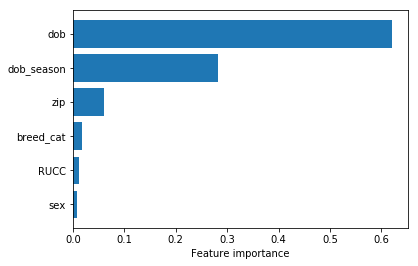

In [36]:
plot_importances(boost_model.feature_importances_, f_names)

The two strongest features are `dob` and `dob_season`.

### Relationship between date of birth and case status

The gradient boosted tree model suggested that `dob` has an impact on case status. Let's explore the relationship between these variables. First we will compute the (future) case prevalance for each cohort of patients born in the same month.

In [10]:
"""
Create a new dataframe, create column for year, month, and week number.
"""
df = pd.read_csv("data.csv")

for i in range(len(df['dob'])):
    item = df['dob'][i]
    if isinstance(item, str):
        dt = datetime.strptime(df['dob'][i], '%Y-%m-%d')
        df['dob'][i] = dt


df['year'] = df['dob'].dt.year
df['month'] = df['dob'].dt.month

"""
Maintain a dictionary of the form:
    dict[year] = [list1, list2]

where list1 is a list of case counts in each of the 12 months, and list2 is a
similar list of counts of non-cases.
"""
dict = {}
for i in range(len(df['dob'])):
    if np.isnan(df['month'][i])==False and np.isnan(df['year'][i])==False:
        y = int(df['year'][i])
        m = int(df['month'][i])-1
        
        if y in dict:
            if df['case'][i] == 1:
                cases = dict[y][0]
                cases[m] += 1
            
            else:
                not_cases = dict[y][1]
                not_cases[m] += 1
                    
        else:
            dict[y] = [np.zeros((12,), dtype='int'), np.zeros((12,), dtype='int')]

"""
Use the dictionary to calculate the monthly case prevalance.
    x_vals - represents a string of the form year-month designating the patient's date of birth
    y_vals - eventual case prevalance for all patients born in the corresponding year and month
"""
y_vals = []
x_vals = []
for year in dict.keys():
    cases = dict[year][0]
    not_cases = dict[year][1]
    
    for month in range(12):
        c = cases[month]
        nc = not_cases[month]
        if c == 0 and nc == 0:
            freq = float('NaN')
        else:
            freq = c /(c + nc)        
        y_vals.append(freq)
        string = str(year)+"-"+str(month+1).zfill(2)
        x_vals.append(datetime.strptime(string, "%Y-%m"))

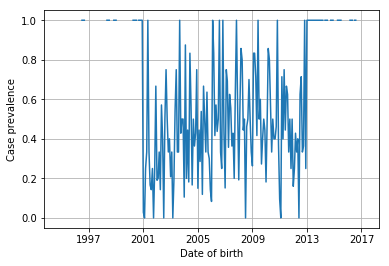

In [11]:
"""
Visualize the data
""" 
x, y = zip(*sorted(zip(x_vals,y_vals)))

fig, ax = plt.subplots()       
plt.plot(x, y)
ax.grid()
ax.set(xlabel='Date of birth', ylabel='Case prevalence')
plt.show()
fig.savefig("vis.png", dpi=400)
plt.close()

Suprisingly, there is a unique historical relationship between `dob` and eventual case prevalence, in which all patients born prior to 2001 presented as atopy cases, as did all patients born after 2013 in this data set. Put differently, there are no controls born prior to 2001 or after 2013. This unusual historical pattern is likely to account for most of the importance this feature.

### Repeating the experiment without date of birth

It is conceivable that there is signal in `dob` beyond the thresholded historical pattern indicated by the previous analysis, such as seasonality within the intervening time frame. The `dob_season` is after all the second most important feature in the gradient boosted tree model. Therefore, it makes sense to remove `dob` from $X$ and see if there is predictive signal in the remaining features.

In [39]:
experiment2(data, drop_dob = True)

******************* FOLD 1 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******************* FOLD 2 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******************* FOLD 3 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******************* FOLD 4 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


******************* FOLD 5 *******************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


*******************SVM*******************

Acc 0.6710 (0.6514, 0.6901) 
F1 0.4437 (0.4100, 0.4767) 
AUC 0.5239 (0.4949, 0.5548) 

*******************RF********************

Acc 0.7422 (0.7234, 0.7603) 
F1 0.5339 (0.5008, 0.5663) 
AUC 0.6080 (0.5762, 0.6386) 

*******************Tree******************

Acc 0.7052 (0.6870, 0.7234) 
F1 0.4839 (0.4494, 0.5164) 
AUC 0.5610 (0.5304, 0.5919) 

*******************Bagging***************

Acc 0.7325 (0.7141, 0.7514) 
F1 0.5322 (0.4980, 0.5650) 
AUC 0.6031 (0.5704, 0.6320) 

*******************Boosting**************

Acc 0.7350 (0.7172, 0.7523) 
F1 0.5319 (0.4967, 0.5635) 
AUC 0.6040 (0.5728, 0.6350) 

*******************LR********************



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Acc 0.7079 (0.6883, 0.7274) 
F1 0.0000 (0.0000, 0.0000) 
AUC 0.6460 (0.6367, 0.6552) 



We observe a marked drop in the performance of all models, with most of the performance scores now dropping below those of the baseline classifier. For several of the tree-based ensemble approaches, the F1-score is significantly higher than baseline, but this is not true for the PR AUC.

### Summary: Predicting case vs. control

We conclude that ***the majority, if not all, of the predictive signal relevant to CAD case vs. control prediction is in the unique historical pattern of the `dob` feature.***